In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import talib
import os
from utils import get_model_inputs, seed_everything, load_stock_data
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from models import MLP, Seq2Seq, RNNmodel

from joblib import dump, load
device = 'cuda'

### Load data and models

In [2]:
full_data = pd.read_csv('ASX100.csv')
n_back = 20
n_forward = 5

seed_everything(1)
train_data, test_data, scalers = load_stock_data(full_data, n_back, test_date_split="2019-01-01", TI=True)
all_stocks = list(train_data.keys())
n_weeks = test_data[list(all_stocks)[0]].iloc[n_back:].shape[0]//5

input_data = {stock: get_model_inputs(stock, train_data, n_back, n_forward) for stock in all_stocks}

x = np.concatenate([input_data[stock][0] for stock in all_stocks], axis=0)
y = np.concatenate([input_data[stock][1] for stock in all_stocks], axis=0)

In [11]:
hidden_size = 150
mlp = MLP(n_back, hidden_size, n_forward)
mlp.load_model('./model_checkpoints/mlp.model')

input_dim = 10
hidden_dim = 2000
num_layers = 1 
gru = RNNmodel(input_dim, hidden_dim, num_layers, n_forward, 'gru', device=device)
gru.load_model('./model_checkpoints/gru_100_2000_7000_07.pt')


rnn_num_layers = 1
input_feature_len = 10
hidden_size = 2000
rnn_type = 'gru'
seq2seq = Seq2Seq(input_feature_len, hidden_size, rnn_num_layers, n_back, attn_dim=None, rnn_type=rnn_type, use_attn=False, device=device)
seq2seq.load_model('./model_checkpoints/seq2seq_90_2000_6000_005.pt')

rnn_num_layers = 1
input_feature_len = 10
hidden_size = 2000
rnn_type = 'gru'
seq2seq_attn = Seq2Seq(input_feature_len, hidden_size, rnn_num_layers, n_back, attn_dim=None, rnn_type=rnn_type, use_attn=True, device=device)
seq2seq_attn.load_model('./model_checkpoints/seq2seq_attn_15_2000_4500_005.pt')

all_models = dict(zip(['mlp', 'gru', 'seq2seq', 'seq2seq_attention'], [mlp, gru, seq2seq, seq2seq_attn]))

#### Feature importance

In [ ]:
np.random.seed(1)
x_impt = x[np.random.randint(0, x.shape[0], size=(5000,)), :, :]
feat_imp_heat = {}
for model_name in all_models:
    feat_imp_heat[model_name] = np.zeros(x_impt.shape[1:])
    for day in range(x_impt.shape[1]):
        for feat in range(x_impt.shape[2]):
            x_pertub = x_impt.copy()
            x_pertub[:,day,feat] = x_pertub[:,day,feat] + np.random.normal(0., 0.2, size=(x_impt.shape[0],))
            if model_name == 'seq2seq' or model_name == 'seq2seq_attention':
                y_pertub = all_models[model_name].predict(torch.from_numpy(x_pertub).to(device), n_forward)[:,:,0].cpu()
                y_pred = all_models[model_name].predict(torch.from_numpy(x_impt).to(device), n_forward)[:,:,0].cpu()
            elif model_name == 'gru':
                y_pertub = all_models[model_name].predict(torch.from_numpy(x_pertub).to(device)).cpu()
                y_pred = all_models[model_name].predict(torch.from_numpy(x_impt).to(device)).cpu()
            elif model_name == 'mlp':
                y_pertub = all_models[model_name].predict(x_pertub.reshape(x_pertub.shape[0], -1))
                y_pred = all_models[model_name].predict(x_impt.reshape(x_impt.shape[0], -1))

            pertub_err = mean_squared_error(y_pertub, y_pred, squared=False)
            feat_imp_heat[model_name][day, feat] = pertub_err

D:\Miniconda3\envs\py3.7\lib\site-packages\seaborn\matrix.py:277: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmap=self.cmap, **kws)


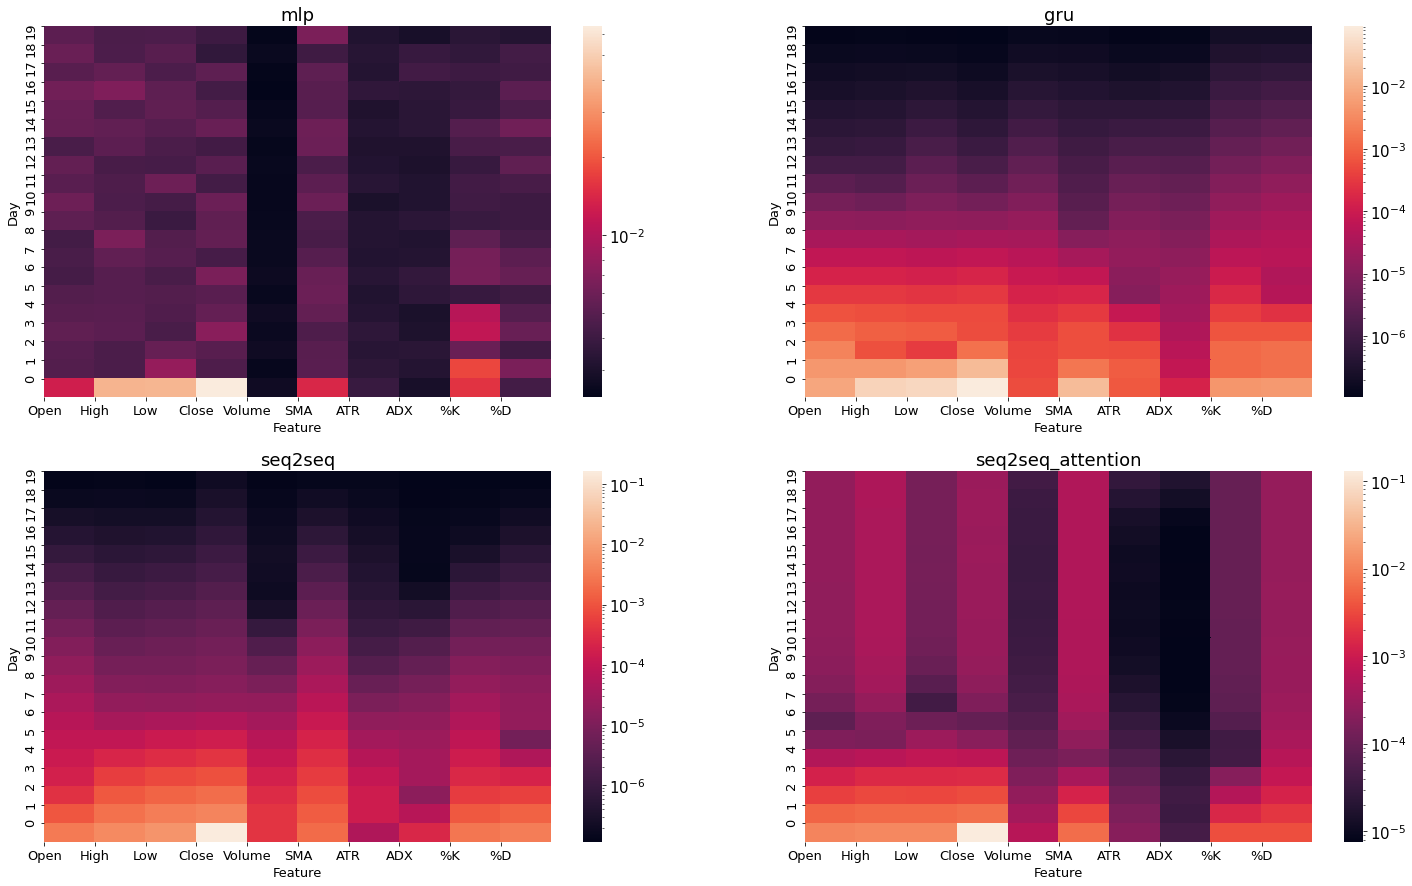

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(25,15))
axs = axs.flatten()
plt.rcParams.update({'font.size': 15})
feat_lab = ['Open','High', 'Low', 'Close', 'Volume', 'SMA', 'ATR', 'ADX', '%K', '%D']
for i, _model in enumerate(all_models):
    _ = sns.heatmap((feat_imp_heat[_model]), ax = axs[i], norm=LogNorm())
    axs[i].set_title(_model)
    axs[i].set_xticks(np.arange(10))
    axs[i].set_yticks(np.arange(20)[::-1])
    axs[i].set_xticklabels(feat_lab)
    axs[i].set_yticklabels(np.arange(20))
    axs[i].set_ylabel('Day')
    axs[i].set_xlabel('Feature')
plt.show()

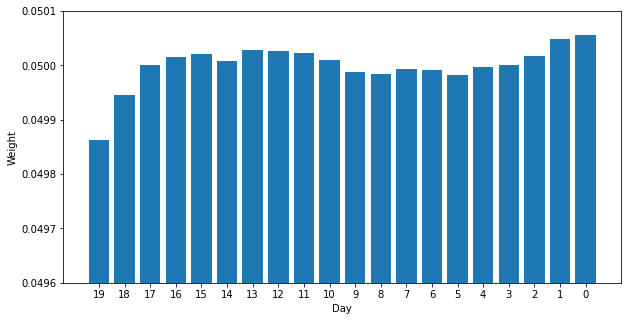

In [7]:
np.random.seed(3)
x_impt = x[np.random.randint(0, x.shape[0], size=(5000,)), :, :]
predictions, attn_weights = all_models['seq2seq_attention'].predict(torch.from_numpy(x_impt).to(device), 5, True)
fig, ax = plt.subplots(1,1,figsize=(10,5))
_ = ax.bar(x = np.arange(20), height = torch.cat(attn_weights, dim=-1).mean(dim=-1).mean(dim=0).cpu().numpy(),) 
#         yerr = torch.cat(attn_weights, dim=-1).mean(dim=-1).std(dim=0).cpu().numpy())
_ = ax.set_xticks(np.arange(20))
_ = ax.set_xticklabels(np.arange(20)[::-1])
_ = ax.set_ylabel('Weight')
_ = ax.set_xlabel('Day')
_ = ax.set_ylim(0.0496,0.0501)
# _ = ax.set_yscale("symlog")

### Metrics

In [5]:
def test_stock_predict(stock, all_models):
    result = {}
    for _model in all_models:
        predictions, true_values = all_models[_model].test_predict(stock, test_data, scalers, n_back, n_forward)
        result[_model] = predictions
    return result, true_values

In [6]:
metrics = {}
for i in range(n_forward):
    metrics[i] = {model: all_models[model].get_metrics(all_stocks, test_data, scalers, n_back, n_forward, day_ahead=i) for model in all_models}
metrics['avg'] = {model: all_models[model].get_metrics(all_stocks, test_data, scalers, n_back, n_forward, day_ahead=None) for model in all_models}

In [9]:
metrics_df = {}
day_ahead = 4#'avg'
for _metric in ['rmse', 'mae', 'mape']:
    _metrics_df = {'stock': all_stocks}
    for _model in all_models:
        _metrics_df[_model] = metrics[day_ahead][_model][_metric].tolist()
    _metrics_df = pd.DataFrame(_metrics_df) 
    metrics_df[_metric] = _metrics_df

In [12]:
for _metric in metrics_df:
    print(_metric)
    print(metrics_df[_metric].mean())
    print(metrics_df[_metric].std())
    print()

rmse
mlp                  1.452370
gru                  1.277415
seq2seq              1.192529
seq2seq_attention    1.207405
dtype: float64
mlp                  2.450782
gru                  2.025308
seq2seq              1.828190
seq2seq_attention    1.872657
dtype: float64

mae
mlp                  1.127588
gru                  0.965591
seq2seq              0.883016
seq2seq_attention    0.897884
dtype: float64
mlp                  1.964137
gru                  1.591783
seq2seq              1.397974
seq2seq_attention    1.433441
dtype: float64

mape
mlp                  0.047712
gru                  0.042087
seq2seq              0.039482
seq2seq_attention    0.040074
dtype: float64
mlp                  0.018535
gru                  0.015349
seq2seq              0.013334
seq2seq_attention    0.013979
dtype: float64



In [9]:
metrics_df[_metric]

,stock,mlp,gru,seq2seq,seq2seq_attention
0,AGL,0.517665,0.463714,0.456618,0.464050
1,ALL,1.466411,1.184642,1.176881,1.181765
2,ALQ,0.335840,0.303874,0.297787,0.294890
3,ALU,1.987393,1.680864,1.502879,1.475425
4,ALX,0.308220,0.250596,0.245199,0.248235
...,...,...,...,...,...
86,WES,1.327623,1.384986,1.211808,1.206165
87,WOR,0.672080,0.624004,0.620628,0.631913
88,WOW,1.123682,1.001868,0.907131,0.904710
89,WPL,1.054606,1.018122,0.986582,0.978428


In [7]:
dmetrics_df['mape'].sort_values('mlp')

,stock,mlp,gru,seq2seq,seq2seq_attention
10,AST,0.017029,0.015009,0.014774,0.014629
74,SKI,0.019513,0.018365,0.018514,0.018532
5,AMC,0.019719,0.019167,0.019160,0.019797
48,MPL,0.019751,0.018359,0.018324,0.018364
22,CBA,0.020071,0.019635,0.019303,0.019339
...,...,...,...,...,...
46,MFG,0.053929,0.082422,0.068771,0.071929
36,FMG,0.054512,0.058388,0.049786,0.051452
68,SAR,0.056437,0.057746,0.049897,0.050644
6,AMP,0.091725,0.074490,0.057548,0.054076


In [69]:
metrics_df['mape'].sort_values('gru')

,stock,mlp,gru,seq2seq,seq2seq_attention
10,AST,0.017029,0.015009,0.014774,0.014629
48,MPL,0.019751,0.018359,0.018324,0.018364
74,SKI,0.019513,0.018365,0.018514,0.018532
20,BXB,0.020287,0.018928,0.018914,0.019465
13,AZJ,0.020575,0.019057,0.019002,0.018974
...,...,...,...,...,...
59,OSH,0.053819,0.057689,0.048822,0.048126
68,SAR,0.056437,0.057746,0.049897,0.050644
36,FMG,0.054512,0.058388,0.049786,0.051452
6,AMP,0.091725,0.074490,0.057548,0.054076


In [70]:
metrics_df['mape'].sort_values('seq2seq')

,stock,mlp,gru,seq2seq,seq2seq_attention
10,AST,0.017029,0.015009,0.014774,0.014629
48,MPL,0.019751,0.018359,0.018324,0.018364
81,TLS,0.024752,0.020127,0.018332,0.018843
11,ASX,0.029482,0.022333,0.018485,0.018333
74,SKI,0.019513,0.018365,0.018514,0.018532
...,...,...,...,...,...
59,OSH,0.053819,0.057689,0.048822,0.048126
36,FMG,0.054512,0.058388,0.049786,0.051452
68,SAR,0.056437,0.057746,0.049897,0.050644
6,AMP,0.091725,0.074490,0.057548,0.054076


In [71]:
metrics_df['mape'].sort_values('seq2seq_attention')

,stock,mlp,gru,seq2seq,seq2seq_attention
10,AST,0.017029,0.015009,0.014774,0.014629
11,ASX,0.029482,0.022333,0.018485,0.018333
48,MPL,0.019751,0.018359,0.018324,0.018364
74,SKI,0.019513,0.018365,0.018514,0.018532
81,TLS,0.024752,0.020127,0.018332,0.018843
...,...,...,...,...,...
35,FLT,0.112861,0.053658,0.048743,0.049442
68,SAR,0.056437,0.057746,0.049897,0.050644
36,FMG,0.054512,0.058388,0.049786,0.051452
6,AMP,0.091725,0.074490,0.057548,0.054076


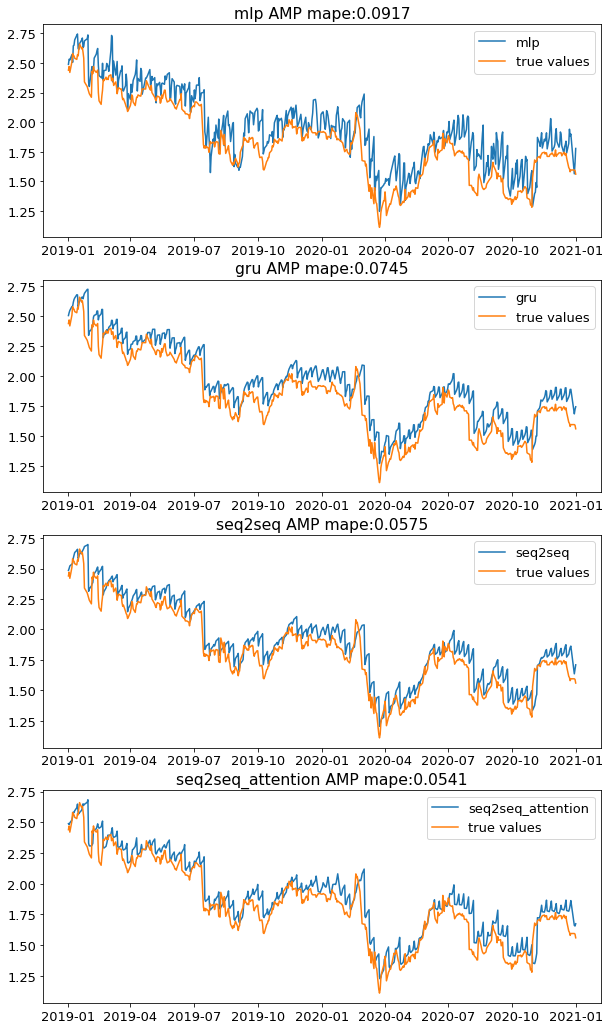

In [25]:
stock = 'AMP'
plt.rcParams.update({'font.size': 13})
predictions, true_values = test_stock_predict(stock, all_models)
fig, axs = plt.subplots(len(predictions), figsize=(10,18))
for i, _models in enumerate(predictions):
    axs[i].plot(pd.to_datetime(test_data[stock].index[n_back:]), predictions[_models], label=_models)
    axs[i].plot(pd.to_datetime(test_data[stock].index[n_back:]), scalers[stock].inverse_transform(test_data[stock])[n_back:,3], label='true values')
#     axs[i].set_xticklabels(test_data[stock].index)
    axs[i].legend()
    axs[i].set_title(_models + ' ' + stock + ' mape:' + str(metrics_df['mape'][metrics_df['mape']['stock'] == stock][_models].round(4).item()))

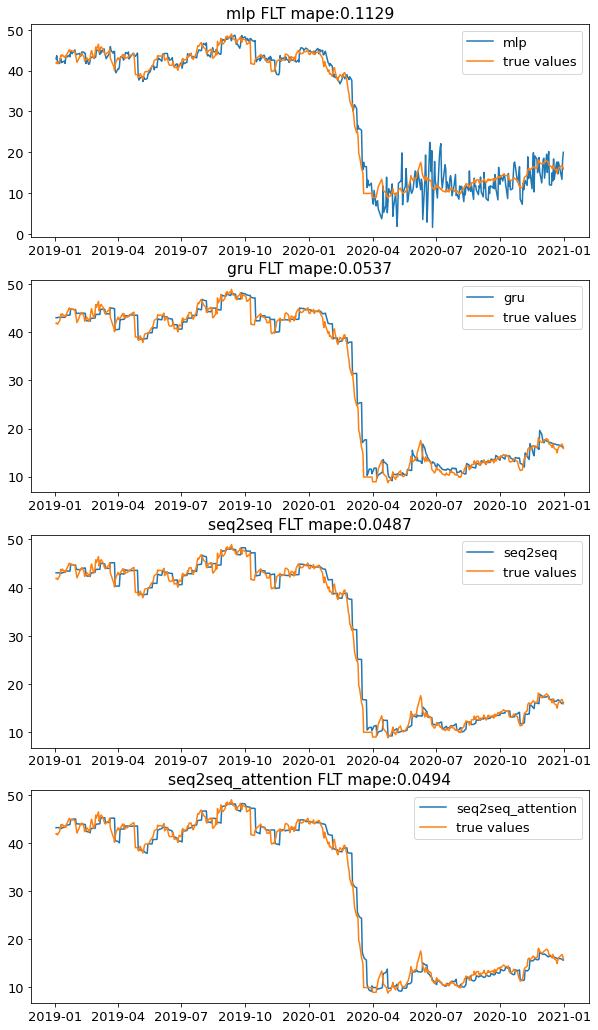

In [74]:
stock = 'FLT'
plt.rcParams.update({'font.size': 13})
predictions, true_values = test_stock_predict(stock, all_models)
fig, axs = plt.subplots(len(predictions), figsize=(10,18))
for i, _models in enumerate(predictions):
    axs[i].plot(pd.to_datetime(test_data[stock].index[n_back:]), predictions[_models], label=_models)
    axs[i].plot(pd.to_datetime(test_data[stock].index[n_back:]), scalers[stock].inverse_transform(test_data[stock])[n_back:,3], label='true values')
#     axs[i].set_xticklabels(test_data[stock].index)
    axs[i].legend()
    axs[i].set_title(_models + ' ' + stock + ' mape:' + str(metrics_df['mape'][metrics_df['mape']['stock'] == stock][_models].round(4).item()))